# Iterative Phase Estimation

This tutorial shows the IPE algorithm applied to a simple problem, estimating the eigenvalue of the |11> state for the CT gate, i.e. diag(1, 1, 1, e^ipi/4). This means PHI=pi/4 and phi=1/8=0.001 in bynary, so it can be represented exactly with m=3 classical bits. For an accurate description of the algorithm see https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/algorithms/iterative_phase_estimation_algorithm.ipynb

In [5]:
from math import pi
import matplotlib.pyplot as plt
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.classical import expr
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
from qiskit_ibm_runtime import QiskitRuntimeService

### Step 1: Map problem to quantum circuits and operators

In [3]:
nq = 3    # number of qubits
m = 3    # number of classical bits

PHI = pi/4

q = QuantumRegister(nq,'q')
c = ClassicalRegister(m,'c')

qc = QuantumCircuit(q,c)

qc.h(0)
qc.x([1, 2])

In [4]:
def x_measurement(qc, qubit, cbit):
    """Measure 'qubit' in the X-basis, and store the result in 'cbit'"""
    qc.h(qubit)
    qc.measure(qubit, cbit)

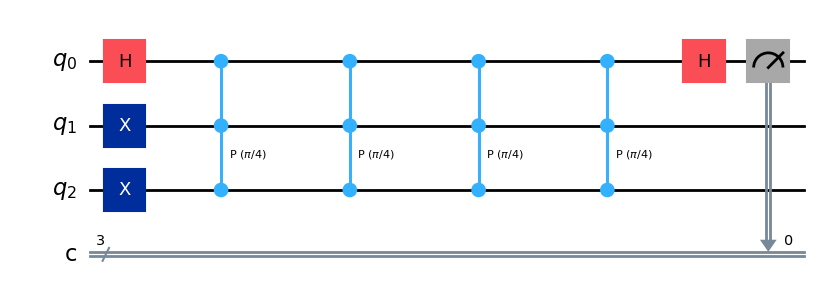

In [5]:
# step 1

for _ in range(2 ** (m - 1)):
    qc.mcp(PHI, [0, 1], 2)

x_measurement(qc, q[0], c[0])
qc.draw('mpl')

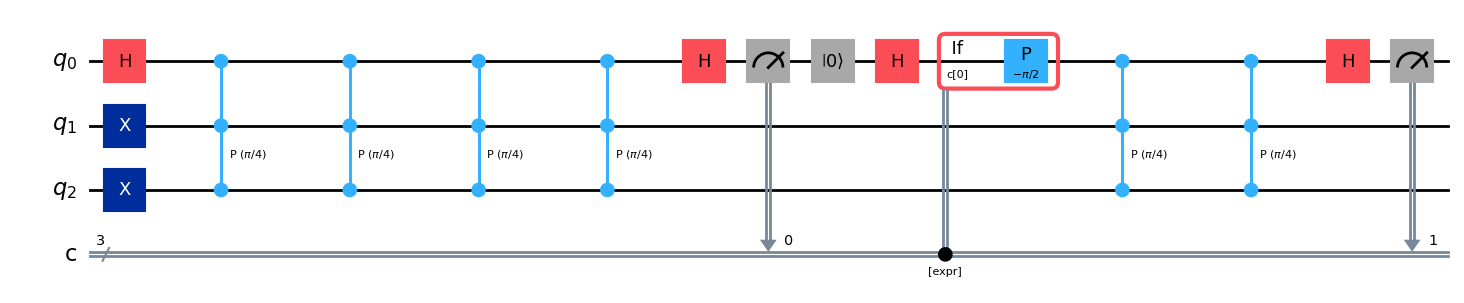

In [6]:
# step 2

qc.reset(0)
qc.h(0)

with qc.if_test(expr.lift(c[0])):
    qc.p(-pi/2, 0) # phase correction

for _ in range(2 ** (m - 2)):
    qc.mcp(PHI, [0, 1], 2)
    
x_measurement(qc, q[0], c[1])
qc.draw('mpl')

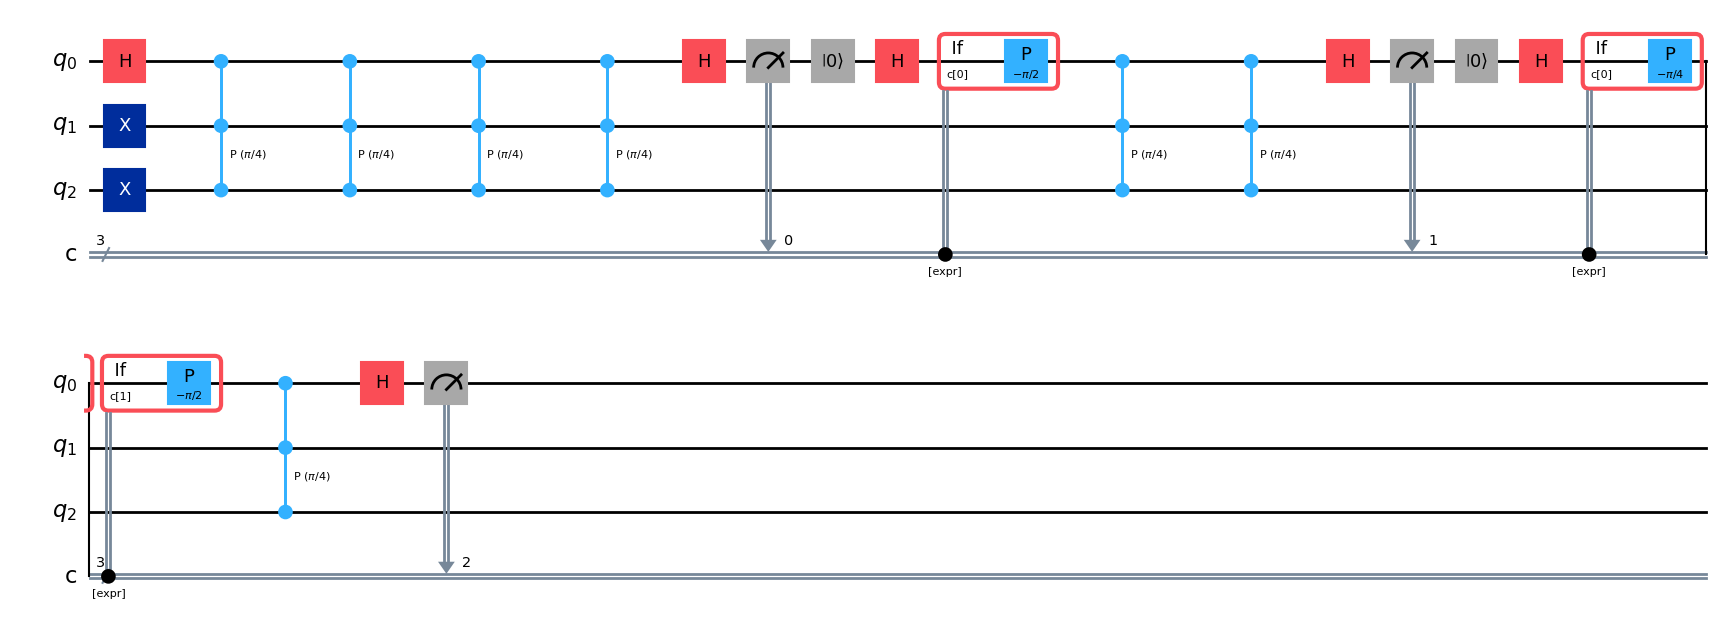

In [7]:
# step 3

qc.reset(0)
qc.h(0)

# phase correction
first = expr.lift(c[0])
second = expr.lift(c[1])

with qc.if_test(first):
    qc.p(-pi/4, 0)

with qc.if_test(second):
    qc.p(-pi/2, 0)

# c-U operations
for _ in range(2 ** (m - 3)):
    qc.mcp(PHI, [0, 1], 2)

# X measurement  
qc.h(0)
qc.measure(0, 2)

qc.draw('mpl')

### Step 2: Optimize for target hardware

In [9]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False, dynamic_circuits=True, use_fractional_gates=False)
print(backend.name)
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

isa_circuit = pm.run(qc)

### Step 3: Execute on target hardware

In [28]:
sampler = Sampler(mode=backend)

job = sampler.run([isa_circuit])

id = job.job_id()
print(id)

### Step 4: Post-process results

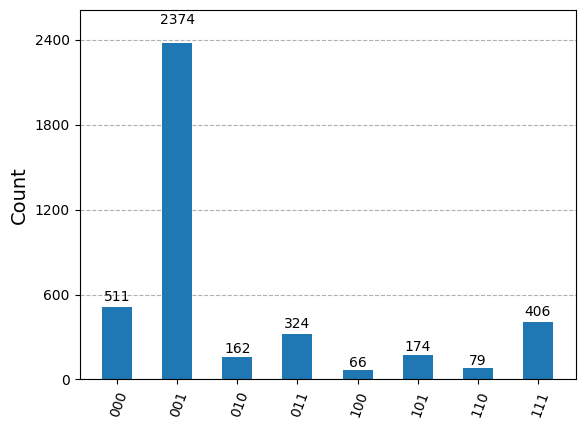

In [10]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
job = service.job(id)
job_result = job.result()
counts = job_result[0].data.c.get_counts()
plot_histogram(counts)

In [9]:
# get the most frequent result
max_key, max_value = max(counts.items(), key=lambda x: x[1])

phi = int(max_key, 2) / 8

print(f'phi = {phi}') # 0.125 (= 1/8 = 0.001 in bynary) as expected

phi = 0.125


In [13]:
! pip freeze | grep qiskit

qiskit==1.1.0
qiskit-aer==0.14.2
qiskit-algorithms==0.3.0
qiskit-ibm-runtime==0.25.0
qiskit-machine-learning==0.7.2
qiskit-nature==0.7.2
qiskit-nature-pyscf==0.4.0
qiskit-qasm3-import==0.5.0
qiskit-transpiler-service==0.4.5
